# Correlation between Price and Emissions

Emissions data: https://www.energidataservice.dk/tso-electricity/DeclarationGridEmission?utm_source=chatgpt.com
Price data: https://www.energidataservice.dk/tso-electricity/elspotprices?utm_source=chatgpt.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="darkgrid")

df_emissions = pd.read_csv("../data/raw/emissions.csv", sep=";", decimal=",")
df_emissions.head()

,HourUTC,HourDK,PriceArea,FuelAllocationMethod,Version,CO2originPerkWh,CO2PerkWh,CH4PerkWh,N2OPerkWh,TFactor,DFactor
0,2025-10-17 20:00:00,2025-10-17 22:00:00,DK2,125%,Preliminary,233.838286,19.472256,9.779297,2.126409,1.015917,1.043865
1,2025-10-17 20:00:00,2025-10-17 22:00:00,DK2,200%,Preliminary,313.610938,25.827113,12.686689,2.861547,1.015917,1.043865
2,2025-10-17 20:00:00,2025-10-17 22:00:00,DK2,Total,Preliminary,453.718936,37.865102,17.667165,4.159133,1.015917,1.043865
3,2025-10-17 19:00:00,2025-10-17 21:00:00,DK2,125%,Preliminary,248.732229,20.191927,13.827282,2.248520,1.016026,1.043749
4,2025-10-17 19:00:00,2025-10-17 21:00:00,DK2,200%,Preliminary,329.769112,26.656961,17.679677,2.993422,1.016026,1.043749


In [2]:
df_prices = pd.read_csv("../data/raw/prices.csv", sep=";", decimal=",")
df_prices.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2025-09-30 21:00:00,2025-09-30 23:00:00,DK2,690.252246,92.480003
1,2025-09-30 20:00:00,2025-09-30 22:00:00,DK2,758.396725,101.610001
2,2025-09-30 19:00:00,2025-09-30 21:00:00,DK2,865.875453,116.010002
3,2025-09-30 18:00:00,2025-09-30 20:00:00,DK2,1098.596737,147.190002
4,2025-09-30 17:00:00,2025-09-30 19:00:00,DK2,2667.188975,357.350006


In [3]:
# Filter emissions to only include 'Final' version
df_emissions_final = df_emissions[df_emissions['Version'] == 'Final'].copy()

# Join prices with emissions on common columns (HourUTC, HourDK, PriceArea)
df_joined = pd.merge(
    df_prices,
    df_emissions_final[['HourUTC', 'HourDK', 'PriceArea', 'CO2PerkWh', 'FuelAllocationMethod']],
    on=['HourUTC', 'HourDK', 'PriceArea'],
    how='left'
)

# Convert HourUTC to datetime for proper sorting
df_joined['HourUTC'] = pd.to_datetime(df_joined['HourUTC'])

# Sort by date
df_joined = df_joined.sort_values('HourUTC').reset_index(drop=True)

# Filter out rows where there is no emissions data available
df_joined = df_joined.dropna(subset=['CO2PerkWh'])

print(f"Shape of joined dataframe: {df_joined.shape}")
print(f"Start date: {df_joined['HourDK'].min()}")
print(f"End date: {df_joined['HourDK'].max()}")
df_joined.head()


Shape of joined dataframe: (85536, 7)
Start date: 2021-10-01 00:00:00
End date: 2024-12-31 23:00:00


,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,CO2PerkWh,FuelAllocationMethod
11064,2021-09-30 22:00:00,2021-10-01 00:00:00,DK2,287.989990,38.730000,49.184670,Total
11065,2021-09-30 22:00:00,2021-10-01 00:00:00,DK2,287.989990,38.730000,33.893860,200%
11066,2021-09-30 22:00:00,2021-10-01 00:00:00,DK2,287.989990,38.730000,26.752375,125%
11067,2021-09-30 23:00:00,2021-10-01 01:00:00,DK2,257.579987,34.639999,51.090076,Total
11068,2021-09-30 23:00:00,2021-10-01 01:00:00,DK2,257.579987,34.639999,35.448594,200%


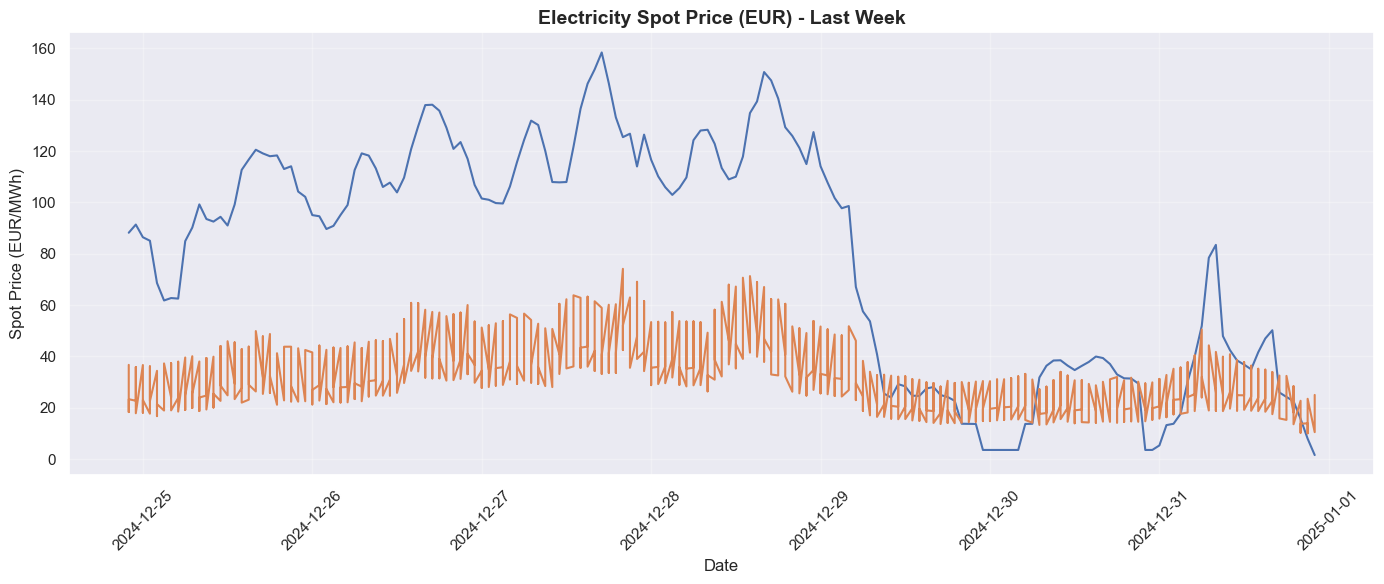

Date range: 2024-12-24 22:00:00 to 2024-12-31 22:00:00
Number of data points: 507


In [4]:
# Get the last week of data
last_date = df_joined['HourUTC'].max()
one_week_ago = last_date - pd.Timedelta(days=7)
df_last_week = df_joined[df_joined['HourUTC'] >= one_week_ago]

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(df_last_week['HourUTC'], df_last_week['SpotPriceEUR'], linewidth=1.5)
plt.plot(df_last_week['HourUTC'], df_last_week['CO2PerkWh'], linewidth=1.5)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Spot Price (EUR/MWh)', fontsize=12)
plt.title('Electricity Spot Price (EUR) - Last Week', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Date range: {df_last_week['HourUTC'].min()} to {df_last_week['HourUTC'].max()}")
print(f"Number of data points: {len(df_last_week)}")


In [5]:
# Calculate Pearson correlation by month
# Extract year and month
df_joined['Year'] = df_joined['HourUTC'].dt.year
df_joined['Month'] = df_joined['HourUTC'].dt.month

# Calculate correlation for each year-month combination
correlation_matrix = []

years = sorted(df_joined['Year'].unique())
months = range(1, 13)

for year in years:
    year_correlations = []
    for month in months:
        # Filter data for this year-month
        mask = (df_joined['Year'] == year) & (df_joined['Month'] == month)
        df_month = df_joined[mask]
        
        if len(df_month) > 1:  # Need at least 2 points for correlation
            corr = df_month['SpotPriceEUR'].corr(df_month['CO2PerkWh'])
            year_correlations.append(corr)
        else:
            year_correlations.append(np.nan)
    
    correlation_matrix.append(year_correlations)

# Convert to DataFrame for better visualization
corr_df = pd.DataFrame(
    correlation_matrix,
    index=years,
    columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

print("Pearson Correlation by Month:")
print(corr_df.round(3))


Pearson Correlation by Month:
        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
2021    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN -0.085  0.424   
2022  0.475  0.479  0.556  0.379  0.472  0.174  0.523  0.477  0.176  0.280   
2023  0.488  0.590  0.487  0.140  0.115  0.261 -0.126  0.347  0.306  0.486   
2024  0.558  0.505  0.288  0.384  0.322  0.189  0.158  0.110 -0.060  0.337   

        Nov    Dec  
2021  0.553  0.454  
2022  0.498  0.556  
2023  0.592  0.605  
2024  0.449  0.580  


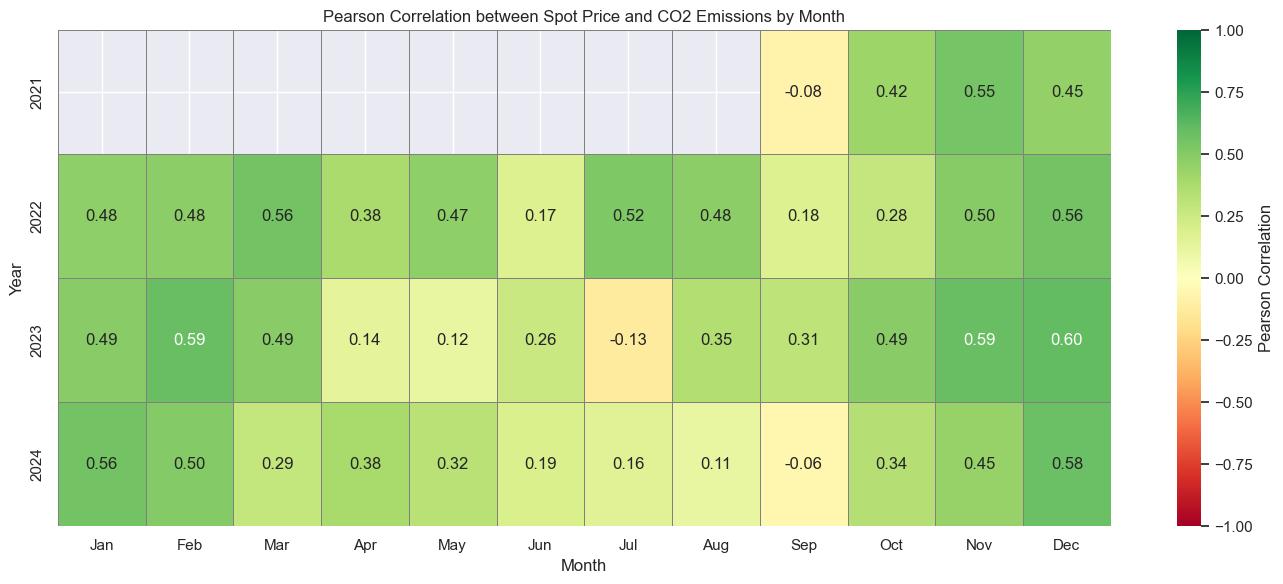


Overall statistics:
Mean correlation: 0.363
Median correlation: 0.437
Min correlation: -0.126
Max correlation: 0.605


In [6]:
# Create heatmap of Pearson correlations
plt.figure(figsize=(14, 6))

# Create heatmap
sns.heatmap(
    corr_df,
    annot=True,  # Show correlation values in cells
    fmt='.2f',   # Format to 2 decimal places
    cmap='RdYlGn',  # Red-Yellow-Green colormap (red=negative, green=positive)
    center=0,    # Center colormap at 0
    vmin=-1,     # Correlation ranges from -1 to 1
    vmax=1,
    cbar_kws={'label': 'Pearson Correlation'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Pearson Correlation between Spot Price and CO2 Emissions by Month')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nOverall statistics:")
print(f"Mean correlation: {corr_df.values[~np.isnan(corr_df.values)].mean():.3f}")
print(f"Median correlation: {np.nanmedian(corr_df.values):.3f}")
print(f"Min correlation: {np.nanmin(corr_df.values):.3f}")
print(f"Max correlation: {np.nanmax(corr_df.values):.3f}")


In [7]:
# Calculate Spearman correlation by month
from scipy.stats import spearmanr

correlation_matrix_spearman = []

for year in years:
    year_correlations = []
    for month in months:
        # Filter data for this year-month
        mask = (df_joined['Year'] == year) & (df_joined['Month'] == month)
        df_month = df_joined[mask]
        
        if len(df_month) > 1:  # Need at least 2 points for correlation
            corr, _ = spearmanr(df_month['SpotPriceEUR'], df_month['CO2PerkWh'])
            year_correlations.append(corr)
        else:
            year_correlations.append(np.nan)
    
    correlation_matrix_spearman.append(year_correlations)

# Convert to DataFrame
corr_spearman_df = pd.DataFrame(
    correlation_matrix_spearman,
    index=years,
    columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

print("Spearman Correlation by Month:")
print(corr_spearman_df.round(3))


Spearman Correlation by Month:
        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
2021    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN -0.293  0.446   
2022  0.566  0.452  0.630  0.482  0.553  0.194  0.569  0.508  0.176  0.405   
2023  0.415  0.645  0.517  0.246  0.176  0.302  0.034  0.304  0.341  0.520   
2024  0.702  0.553  0.332  0.357  0.207  0.079  0.087  0.069  0.057  0.363   

        Nov    Dec  
2021  0.628  0.470  
2022  0.562  0.577  
2023  0.580  0.626  
2024  0.609  0.604  


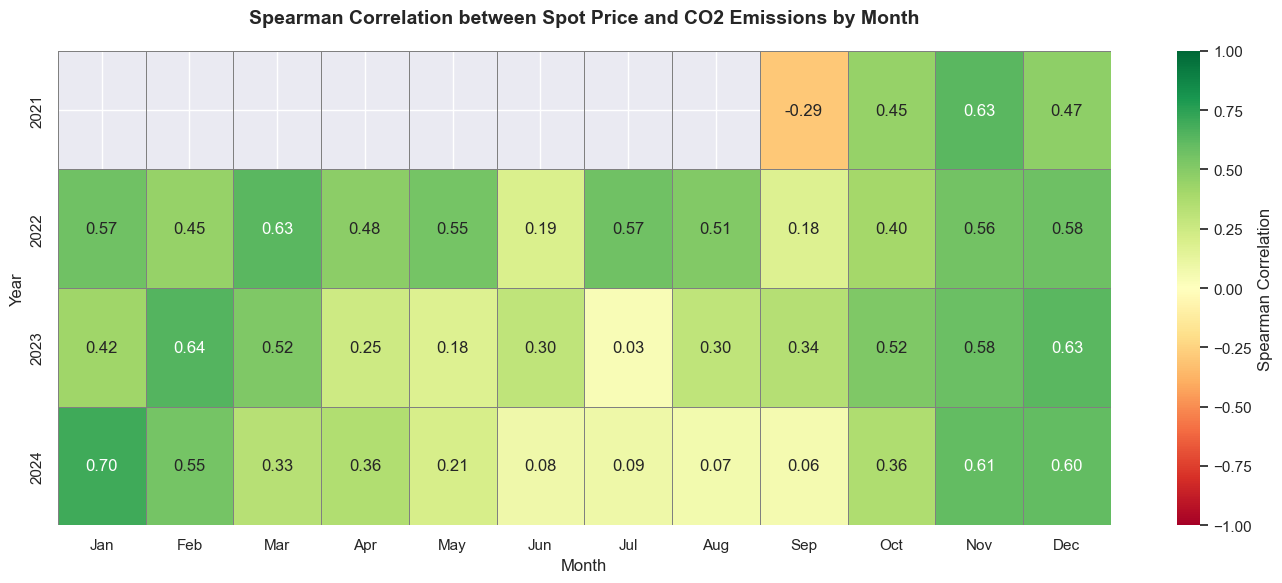


Overall statistics:
Mean correlation: 0.391
Median correlation: 0.449
Min correlation: -0.293
Max correlation: 0.702


In [8]:
# Create heatmap of Spearman correlations
plt.figure(figsize=(14, 6))

# Create heatmap
sns.heatmap(
    corr_spearman_df,
    annot=True,  # Show correlation values in cells
    fmt='.2f',   # Format to 2 decimal places
    cmap='RdYlGn',  # Red-Yellow-Green colormap (red=negative, green=positive)
    center=0,    # Center colormap at 0
    vmin=-1,     # Correlation ranges from -1 to 1
    vmax=1,
    cbar_kws={'label': 'Spearman Correlation'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Spearman Correlation between Spot Price and CO2 Emissions by Month', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nOverall statistics:")
print(f"Mean correlation: {corr_spearman_df.values[~np.isnan(corr_spearman_df.values)].mean():.3f}")
print(f"Median correlation: {np.nanmedian(corr_spearman_df.values):.3f}")
print(f"Min correlation: {np.nanmin(corr_spearman_df.values):.3f}")
print(f"Max correlation: {np.nanmax(corr_spearman_df.values):.3f}")


In [9]:
# Extract hour from datetime
df_joined['Hour'] = df_joined['HourUTC'].dt.hour

# Calculate Pearson correlation by hour of day and month
correlation_matrix_hour_month = []

hours = range(24)
months = range(1, 13)

for hour in hours:
    hour_correlations = []
    for month in months:
        # Filter data for this hour-month combination (across all years)
        mask = (df_joined['Hour'] == hour) & (df_joined['Month'] == month)
        df_hour_month = df_joined[mask]
        
        if len(df_hour_month) > 1:  # Need at least 2 points for correlation
            corr = df_hour_month['SpotPriceEUR'].corr(df_hour_month['CO2PerkWh'])
            hour_correlations.append(corr)
        else:
            hour_correlations.append(np.nan)
    
    correlation_matrix_hour_month.append(hour_correlations)

# Convert to DataFrame
corr_hour_month_df = pd.DataFrame(
    correlation_matrix_hour_month,
    index=range(24),
    columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

print("Pearson Correlation by Hour of Day and Month:")
print(corr_hour_month_df.round(3))


Pearson Correlation by Hour of Day and Month:
      Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
0   0.161  0.179  0.663  0.621  0.594  0.499  0.344  0.554  0.188  0.334   
1   0.152  0.171  0.661  0.541  0.549  0.492  0.291  0.582  0.225  0.368   
2   0.139  0.143  0.661  0.529  0.592  0.526  0.338  0.615  0.295  0.379   
3   0.151  0.276  0.635  0.494  0.615  0.529  0.310  0.607  0.325  0.416   
4   0.227  0.407  0.611  0.510  0.564  0.471  0.288  0.579  0.354  0.477   
5   0.258  0.514  0.538  0.562  0.544  0.502  0.273  0.455  0.338  0.507   
6   0.284  0.494  0.579  0.575  0.489  0.595  0.272  0.399  0.380  0.491   
7   0.391  0.510  0.564  0.541  0.447  0.620  0.208  0.522  0.415  0.481   
8   0.359  0.474  0.582  0.440  0.443  0.644  0.129  0.585  0.426  0.513   
9   0.405  0.479  0.577  0.347  0.466  0.621  0.054  0.569  0.275  0.528   
10  0.379  0.457  0.541  0.223  0.417  0.582  0.019  0.499  0.188  0.531   
11  0.383  0.423  0.472  0.169  0.327  0.6

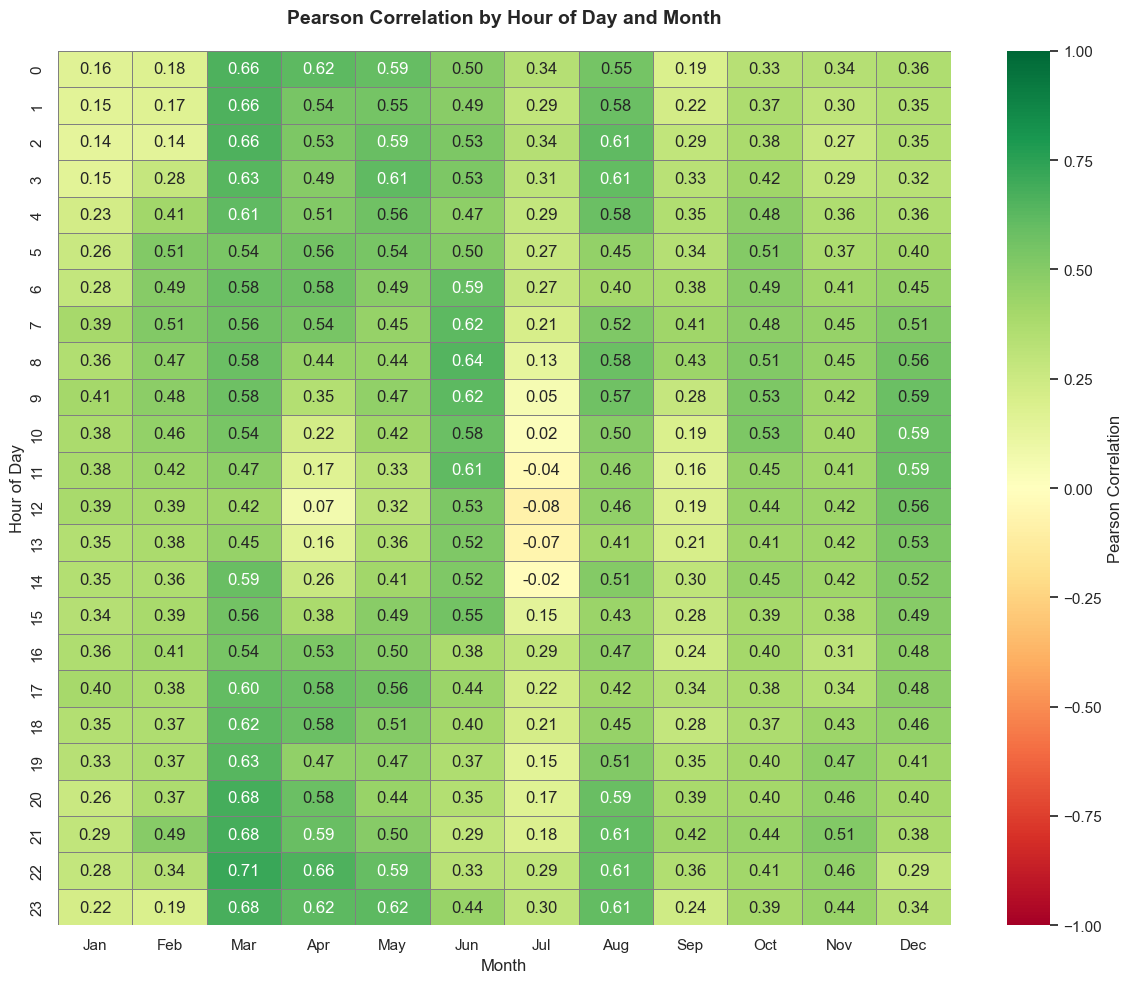


Overall statistics:
Mean correlation: 0.416
Median correlation: 0.418
Min correlation: -0.081
Max correlation: 0.713


In [10]:
# Create heatmap of Pearson correlations by Hour and Month
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(
    corr_hour_month_df,
    annot=True,  # Show correlation values in cells
    fmt='.2f',   # Format to 2 decimal places
    cmap='RdYlGn',  # Red-Yellow-Green colormap (red=negative, green=positive)
    center=0,    # Center colormap at 0
    vmin=-1,     # Correlation ranges from -1 to 1
    vmax=1,
    cbar_kws={'label': 'Pearson Correlation'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Pearson Correlation by Hour of Day and Month', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nOverall statistics:")
print(f"Mean correlation: {corr_hour_month_df.values[~np.isnan(corr_hour_month_df.values)].mean():.3f}")
print(f"Median correlation: {np.nanmedian(corr_hour_month_df.values):.3f}")
print(f"Min correlation: {np.nanmin(corr_hour_month_df.values):.3f}")
print(f"Max correlation: {np.nanmax(corr_hour_month_df.values):.3f}")


In [11]:
# Calculate Spearman correlation by hour of day and month
correlation_matrix_spearman_hour_month = []

for hour in hours:
    hour_correlations = []
    for month in months:
        # Filter data for this hour-month combination (across all years)
        mask = (df_joined['Hour'] == hour) & (df_joined['Month'] == month)
        df_hour_month = df_joined[mask]
        
        if len(df_hour_month) > 1:  # Need at least 2 points for correlation
            corr, _ = spearmanr(df_hour_month['SpotPriceEUR'], df_hour_month['CO2PerkWh'])
            hour_correlations.append(corr)
        else:
            hour_correlations.append(np.nan)
    
    correlation_matrix_spearman_hour_month.append(hour_correlations)

# Convert to DataFrame
corr_spearman_hour_month_df = pd.DataFrame(
    correlation_matrix_spearman_hour_month,
    index=range(24),
    columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

print("Spearman Correlation by Hour of Day and Month:")
print(corr_spearman_hour_month_df.round(3))


Spearman Correlation by Hour of Day and Month:
      Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
0   0.306  0.193  0.554  0.559  0.554  0.583  0.423  0.548  0.229  0.396   
1   0.253  0.178  0.551  0.520  0.530  0.593  0.386  0.542  0.246  0.372   
2   0.170  0.191  0.543  0.523  0.571  0.615  0.404  0.517  0.313  0.416   
3   0.176  0.276  0.543  0.563  0.593  0.572  0.422  0.483  0.349  0.477   
4   0.265  0.369  0.610  0.586  0.636  0.546  0.438  0.527  0.447  0.569   
5   0.298  0.470  0.682  0.591  0.605  0.591  0.425  0.538  0.582  0.637   
6   0.387  0.524  0.684  0.562  0.528  0.643  0.334  0.581  0.600  0.670   
7   0.451  0.523  0.635  0.471  0.432  0.612  0.176  0.599  0.535  0.668   
8   0.445  0.474  0.628  0.330  0.339  0.563  0.054  0.503  0.410  0.669   
9   0.478  0.443  0.595  0.224  0.316  0.477 -0.064  0.365  0.228  0.687   
10  0.488  0.457  0.509  0.178  0.245  0.397 -0.174  0.219  0.085  0.632   
11  0.494  0.443  0.446  0.105  0.127  0.

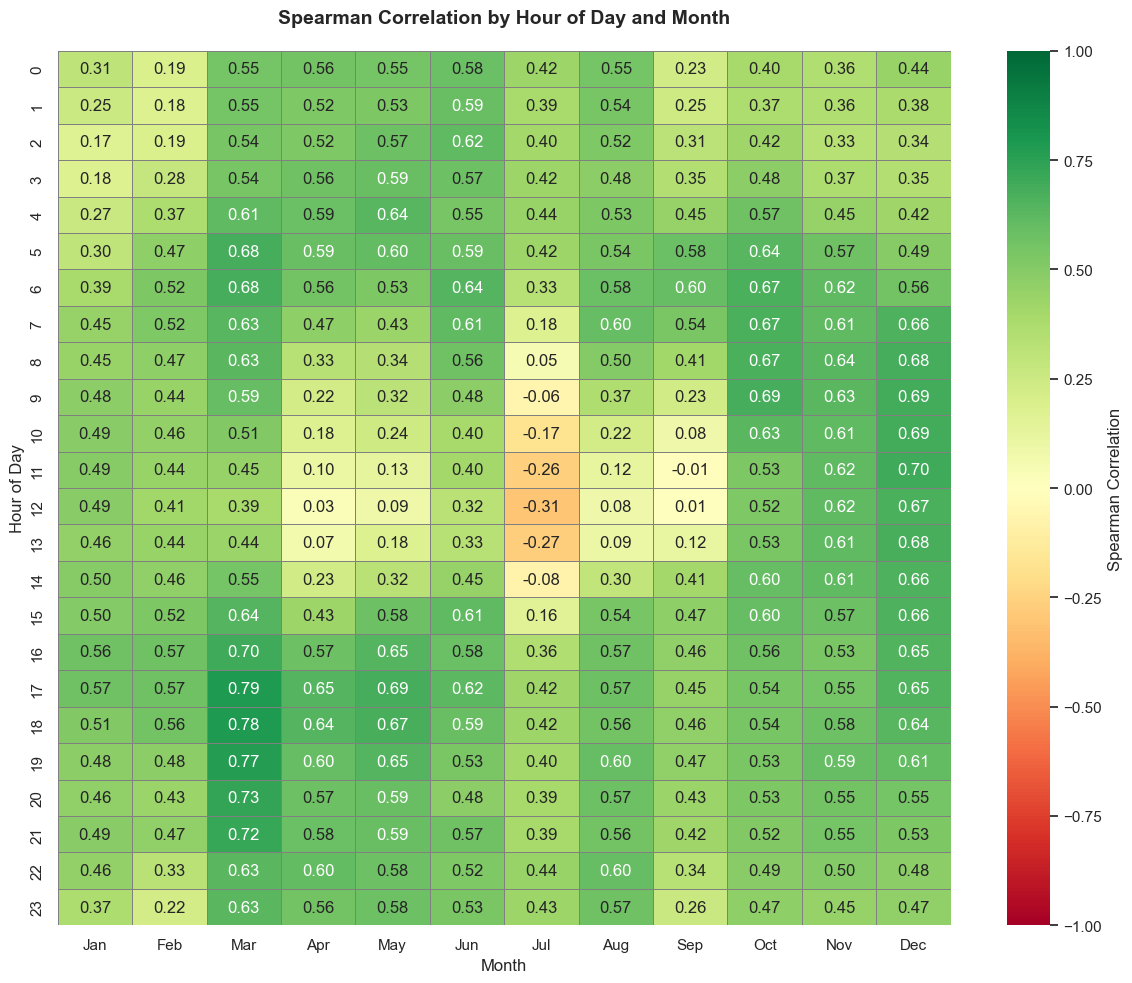


Overall statistics:
Mean correlation: 0.467
Median correlation: 0.519
Min correlation: -0.308
Max correlation: 0.786


In [12]:
# Create heatmap of Spearman correlations by Hour and Month
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(
    corr_spearman_hour_month_df,
    annot=True,  # Show correlation values in cells
    fmt='.2f',   # Format to 2 decimal places
    cmap='RdYlGn',  # Red-Yellow-Green colormap (red=negative, green=positive)
    center=0,    # Center colormap at 0
    vmin=-1,     # Correlation ranges from -1 to 1
    vmax=1,
    cbar_kws={'label': 'Spearman Correlation'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Spearman Correlation by Hour of Day and Month', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nOverall statistics:")
print(f"Mean correlation: {corr_spearman_hour_month_df.values[~np.isnan(corr_spearman_hour_month_df.values)].mean():.3f}")
print(f"Median correlation: {np.nanmedian(corr_spearman_hour_month_df.values):.3f}")
print(f"Min correlation: {np.nanmin(corr_spearman_hour_month_df.values):.3f}")
print(f"Max correlation: {np.nanmax(corr_spearman_hour_month_df.values):.3f}")


In [ ]:
# Formal Hypothesis Test for Correlation between Prices and Emissions

print("=" * 80)
print("HYPOTHESIS TEST: Correlation between Electricity Spot Prices and CO2 Emissions")
print("=" * 80)
print()

print("Null Hypothesis (H₀): There is no correlation between prices and emissions (ρ = 0)")
print("Alternative Hypothesis (H₁): There is a correlation between prices and emissions (ρ ≠ 0)")
print("Significance Level: α = 0.05")
print()

# Extract the variables
prices = df_joined['SpotPriceEUR'].values
emissions = df_joined['CO2PerkWh'].values

print(f"Sample size: n = {len(prices):,} hourly observations")
print(f"Date range: {df_joined['HourDK'].min()} to {df_joined['HourDK'].max()}")
print()

from scipy.stats import pearsonr
pearson_result = pearsonr(prices, emissions)
r_pearson = pearson_result[0]
p_pearson = pearson_result[1]

# 2. Spearman Correlation Test 
spearman_result = spearmanr(prices, emissions)
rho_spearman = spearman_result[0]
p_spearman = spearman_result[1]

# Display results
print("-" * 80)
print("TEST RESULTS")
print("-" * 80)
print()

# Create results table
results_data = {
    'Test': ['Pearson', 'Spearman'],
    'Correlation': [f'{r_pearson:.4f}', f'{rho_spearman:.4f}'],
    'p-value': [f'{p_pearson}', f'{p_spearman}'],
    'Conclusion': ['Reject H₀' if p_pearson < 0.05 else 'Fail to reject H₀',
                   'Reject H₀' if p_spearman < 0.05 else 'Fail to reject H₀']
}

results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False))
print()

HYPOTHESIS TEST: Correlation between Electricity Spot Prices and CO2 Emissions

Null Hypothesis (H₀): There is no correlation between prices and emissions (ρ = 0)
Alternative Hypothesis (H₁): There is a correlation between prices and emissions (ρ ≠ 0)
Significance Level: α = 0.05

Sample size: n = 85,536 hourly observations
Date range: 2021-10-01 00:00:00 to 2024-12-31 23:00:00

--------------------------------------------------------------------------------
TEST RESULTS
--------------------------------------------------------------------------------

    Test Correlation p-value Conclusion
 Pearson      0.3786     0.0  Reject H₀
Spearman      0.4636     0.0  Reject H₀

